# Deep Generalized Unfolding Networks (DGUNet) for Image Denoising
## OVO Final Project — CentraleSupélec, Masters in Math & AI

**Paper:** Mou, Wang & Zhang, *Deep Generalized Unfolding Networks for Image Restoration*, CVPR 2022  
**Task:** Gaussian Color Image Denoising

---

### Notebook Outline
1. **Setup & Imports**
2. **Background: PGD Unfolding & DGUNet Architecture**
3. **Dataset Preparation** (BSD400 train / BSD68 test + new data)
4. **Model Instantiation & Inspection**
5. **Experiment 1:** Train & evaluate at σ=25 (reproduce paper results)
6. **Experiment 2:** Evaluate at σ=15 and σ=50 (multiple noise levels)
7. **Experiment 3:** Ablation — effect of number of unfolding stages
8. **Experiment 4:** Ablation — with vs. without CSFF
9. **Experiment 5:** Test on new data not in the paper (DIV2K validation / own images)
10. **Visualizations & Analysis**
11. **Conclusions**

---
## 1. Setup & Imports

In [ ]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from IPython.display import display, HTML

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from tqdm import tqdm

# Local modules
from DGUNet import DGUNet
import losses
import utils
from dataset_denoise import GaussianDenoiseTrainDataset, GaussianDenoiseTestDataset

# Reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


---
## 2. Background: PGD Unfolding & DGUNet Architecture

### Problem Formulation

Image restoration seeks to recover a clean image $\mathbf{x}$ from a degraded observation $\mathbf{y}$:

$$\hat{\mathbf{x}} = \arg\min_{\mathbf{x}} \;\frac{1}{2}\|\mathbf{y} - \mathbf{H}\mathbf{x}\|^2 + \lambda\,\Phi(\mathbf{x})$$

The **Proximal Gradient Descent (PGD)** algorithm alternates:

1. **Gradient step:** $\mathbf{z}^{(k)} = \mathbf{x}^{(k-1)} - \rho\,\nabla f(\mathbf{x}^{(k-1)})$
2. **Proximal step:** $\mathbf{x}^{(k)} = \mathrm{prox}_{\lambda\Phi}(\mathbf{z}^{(k)})$

### DGUNet Key Ideas

- **Unfolding:** K iterations of PGD become K network stages
- **Gradient Descent Module (GDM):** Learned ResBlocks approximate $\nabla f$ — no need for an explicit $\mathbf{H}$
- **Proximal Mapping Module (PMM):** U-Net encoder-decoder acts as the proximal operator
- **Cross-Stage Feature Fusion (CSFF):** Encoder/decoder features from stage $k$ flow into stage $k+1$
- **Supervised Attention Module (SAM):** Produces intermediate restored images for deep supervision

The network has 7 stages total: 1 initial + 5 shared-weight middle stages + 1 final stage.

---
## 3. Dataset Preparation

### Datasets Used

| Dataset | Role | # Images | Notes |
|---------|------|----------|-------|
| **BSD400** (+ WED optionally) | Training | 400 | Standard denoising benchmark clean images |
| **BSD68** | Test (paper benchmark) | 68 | Reproduce paper results |
| **Kodak24** | Test (paper benchmark) | 24 | Color images |
| **Urban100** | Test (paper benchmark) | 100 | Structured / high-frequency content |
| **DIV2K validation** | Test (**new data**) | 100 | NOT used in paper — required by project guidelines |

All noise is **synthetic Gaussian** added on-the-fly: $\mathbf{y} = \mathbf{x} + \mathbf{n}$, $\mathbf{n} \sim \mathcal{N}(0, \sigma^2)$

### Download Instructions
Run the cell below to set up dataset paths. You need to download:
- BSD400: https://drive.google.com/file/d/1idKFDkAHJGAFDn1OyXZxsTbOSBx9GS8N
- BSD68: standard test set from https://github.com/clausmichele/CBSD68-dataset
- Kodak24: http://r0k.us/graphics/kodak/
- Urban100: https://github.com/jbhuang0604/SelfExSR
- DIV2K validation: https://data.vision.ee.ethz.ch/cvl/DIV2K/

In [2]:
# ============================================================
# DATASET PATHS — UPDATE THESE TO YOUR LOCAL PATHS
# ============================================================

# DIV2K dataset (download from https://data.vision.ee.ethz.ch/cvl/DIV2K/)
TRAIN_DIV2K = './Datasets/DIV2K_train_HR'   # 800 clean 2K images for training
TEST_DIV2K  = './Datasets/DIV2K_valid_HR'   # 100 clean 2K images for validation (NEW DATA)

# Standard benchmarks (optional, for comparison with paper)
TEST_BSD68  = './Datasets/BSD68'            # 68 images (paper benchmark)
TEST_KODAK  = './Datasets/Kodak24'          # 24 images (paper benchmark)
TEST_URBAN  = './Datasets/Urban100'         # 100 images (paper benchmark)
TEST_OWN    = './Datasets/own_images'       # Your own photos (optional)

SAVE_DIR = './checkpoints'

# Verify training data exists
print("=== Dataset Status ===")
for name, path in [('DIV2K Train', TRAIN_DIV2K), ('DIV2K Valid', TEST_DIV2K)]:
    if os.path.isdir(path):
        n_files = len([f for f in os.listdir(path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        print(f'{name}: {n_files} images found at {path}')
    else:
        print(f'WARNING: {name} not found at {path}')

=== Dataset Status ===
DIV2K Train: 800 images found at ./Datasets/DIV2K_train_HR
DIV2K Valid: 100 images found at ./Datasets/DIV2K_valid_HR


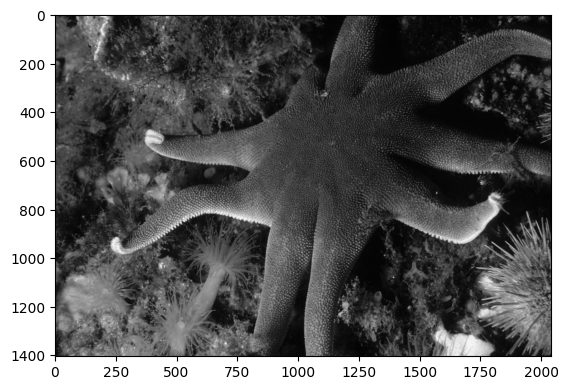

In [3]:
import cv2
import matplotlib.pyplot as plt 

img = cv2.imread('./Datasets/DIV2K_train_HR/0001.png', cv2.IMREAD_GRAYSCALE)
cv2.imshow('image',img)

plt.imshow(img, cmap='gray')


---
## 4. Model Instantiation & Inspection

In [4]:
# Instantiate the default DGUNet (7 stages: 1 + 5 shared + 1)
model = DGUNet(n_feat=80, scale_unetfeats=48, depth=5).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters:     {total_params:>12,}')
print(f'Trainable parameters: {trainable_params:>12,}')

# Quick forward pass test
with torch.no_grad():
    dummy = torch.randn(1, 3, 128, 128).to(device)
    outputs = model(dummy)
    print(f'\nNumber of output stages: {len(outputs)}')
    print(f'Final output shape: {outputs[0].shape}')

Total parameters:       17,331,512
Trainable parameters:   17,331,512

Number of output stages: 7
Final output shape: torch.Size([1, 3, 128, 128])


In [5]:
# Visualize the learned step sizes (r_k parameters)
print('Learned step sizes (r_k) — initialized at 0.5:')
print(f'  Stage 1 (r0): {model.r0.item():.4f}')
for i, p in enumerate(model.basic.parameters()):
    if p.shape == torch.Size([1]):
        print(f'  Stage 2-6 (r_shared): {p.item():.4f}')
        break
print(f'  Stage 7 (r6): {model.r6.item():.4f}')

Learned step sizes (r_k) — initialized at 0.5:
  Stage 1 (r0): 0.5000
  Stage 2-6 (r_shared): 0.5000
  Stage 7 (r6): 0.5000


---
## 5. Experiment 1: Train & Evaluate at σ=25

This is the main experiment reproducing the paper's Gaussian denoising results.

**Paper reports on CBSD68:** ~31.10 dB PSNR at σ=25 for DGUNet.

In [ ]:
# ============================================================
# TRAINING CONFIGURATION
# ============================================================
SIGMA = 25
BATCH_SIZE = 4
PATCH_SIZE = 128
PATCHES_PER_IMAGE = 8
NUM_EPOCHS = 100
LR = 2e-4
LR_MIN = 1e-6
VAL_EVERY = 5
VAL_CENTER_CROP = 256

USE_EDGE_LOSS = False
EDGE_WEIGHT = 0.05

N_FEAT = 80
DEPTH = 5

print(f"Config: sigma={SIGMA}, batch={BATCH_SIZE}, patches/image={PATCHES_PER_IMAGE}")
print(f"Epochs: {NUM_EPOCHS}, LR: {LR}")

In [7]:
def train_model(model, train_dir, val_dir, sigma, num_epochs, batch_size, patch_size,
                lr, lr_min, val_every, use_edge_loss=False, edge_weight=0.05,
                save_dir='./checkpoints', tag='', patches_per_image=1,
                val_center_crop=None, n_feat=80, depth=5):
    """
    Full training loop for DGUNet denoising.
    
    Memory optimizations:
    - patches_per_image: Extract multiple patches per image (more data per epoch)
    - val_center_crop: Use center crops for validation instead of full 2K images
    - gradient accumulation alternative: reduce batch_size and increase patches_per_image
    
    Returns training history dict.
    """
    ckpt_dir = os.path.join(save_dir, f'sigma{sigma}_{tag}' if tag else f'sigma{sigma}')
    os.makedirs(ckpt_dir, exist_ok=True)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-8)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=lr_min)

    criterion_char = losses.CharbonnierLoss()
    criterion_edge = losses.EdgeLoss() if use_edge_loss else None

    # Training dataset with multiple patches per image
    train_dataset = GaussianDenoiseTrainDataset(
        train_dir, patch_size=patch_size, sigma=sigma, 
        patches_per_image=patches_per_image
    )
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=4, drop_last=True, pin_memory=True
    )
    
    # Validation dataset with center crop (memory-efficient for DIV2K)
    val_dataset = GaussianDenoiseTestDataset(
        val_dir, sigma=sigma, center_crop=val_center_crop
    )
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

    print(f"Training: {len(train_dataset)} patches from {len(train_dataset)//patches_per_image} images")
    print(f"Validation: {len(val_dataset)} images" + 
          (f" (center crop {val_center_crop}×{val_center_crop})" if val_center_crop else " (full resolution)"))

    mixup = utils.MixUp_AUG()

    history = {'train_loss': [], 'val_psnr': [], 'lr': []}
    best_psnr = 0

    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        epoch_loss = 0
        for clean, noisy in tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}', leave=False):
            clean, noisy = clean.to(device), noisy.to(device)
            if epoch > 5:
                clean, noisy = mixup.aug(clean, noisy)

            for p in model.parameters():
                p.grad = None

            restored = model(noisy)
            
            # Deep supervision loss across all stages
            loss = sum(criterion_char(torch.clamp(s, 0, 1), clean) for s in restored)
            if criterion_edge is not None:
                loss += edge_weight * sum(criterion_edge(torch.clamp(s, 0, 1), clean) for s in restored)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        history['lr'].append(scheduler.get_last_lr()[0])

        # --- Validation ---
        if epoch % val_every == 0 or epoch == num_epochs:
            model.eval()
            psnrs = []
            with torch.no_grad():
                for clean, noisy, _ in val_loader:
                    clean, noisy = clean.to(device), noisy.to(device)
                    restored = torch.clamp(model(noisy)[0], 0, 1)
                    for r, t in zip(restored, clean):
                        psnrs.append(utils.torchPSNR(r, t).item())

            avg_psnr = np.mean(psnrs)
            history['val_psnr'].append((epoch, avg_psnr))
            print(f'Epoch {epoch} | Loss: {avg_loss:.4f} | Val PSNR: {avg_psnr:.2f} dB | LR: {scheduler.get_last_lr()[0]:.2e}')

            if avg_psnr > best_psnr:
                best_psnr = avg_psnr
                torch.save({'epoch': epoch, 'state_dict': model.state_dict(),
                            'optimizer': optimizer.state_dict(), 'best_psnr': best_psnr},
                           os.path.join(ckpt_dir, 'model_best.pth'))
                print(f'  -> New best model saved!')
        else:
            if epoch % 10 == 0:
                print(f'Epoch {epoch} | Loss: {avg_loss:.4f}')

    # Save final
    torch.save({'epoch': num_epochs, 'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(), 'best_psnr': best_psnr},
               os.path.join(ckpt_dir, 'model_latest.pth'))

    print(f'\nTraining complete. Best validation PSNR: {best_psnr:.2f} dB')
    return history

In [ ]:
# ============================================================
# TRAINING
# ============================================================
# Option 1: Train in notebook (uncomment below)
# 
# model_sigma25 = DGUNet(n_feat=N_FEAT, scale_unetfeats=48, depth=DEPTH).to(device)
# history_25 = train_model(
#     model_sigma25, TRAIN_DIV2K, TEST_DIV2K,
#     sigma=SIGMA, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
#     patch_size=PATCH_SIZE, lr=LR, lr_min=LR_MIN, val_every=VAL_EVERY,
#     patches_per_image=PATCHES_PER_IMAGE, val_center_crop=VAL_CENTER_CROP
# )

# Option 2: Train via command line (recommended for long training)
# Run in terminal:
#   python train.py --train_dir ./Datasets/DIV2K_train_HR --val_dir ./Datasets/DIV2K_valid_HR --sigma 25 --epochs 100

print("Training command:")
print(f"  python train.py --train_dir {TRAIN_DIV2K} --val_dir {TEST_DIV2K} --sigma {SIGMA} --epochs {NUM_EPOCHS}")

In [ ]:
# ============================================================
# LOAD TRAINED MODEL
# ============================================================
from collections import OrderedDict

CHECKPOINT_PATH = f'./checkpoints/dgunet_sigma{SIGMA}/model_best.pth'

if os.path.exists(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
    
    model_sigma25 = DGUNet(n_feat=N_FEAT, scale_unetfeats=48, depth=DEPTH).to(device)
    state_dict = ckpt['state_dict']
    new_sd = OrderedDict((k.replace('module.', ''), v) for k, v in state_dict.items())
    model_sigma25.load_state_dict(new_sd)
    model_sigma25.eval()
    
    print(f"Loaded checkpoint: {CHECKPOINT_PATH}")
    print(f"  Epoch: {ckpt['epoch']}")
    print(f"  Best PSNR: {ckpt['best_psnr']:.2f} dB")
else:
    print(f"Checkpoint not found: {CHECKPOINT_PATH}")
    print("Run training first with the command above.")

### Evaluate on all benchmark test sets

In [ ]:
def evaluate_on_dataset(model, test_dir, sigma, dataset_name=''):
    """Evaluate model on a test set. Returns (avg_psnr, avg_ssim, per_image_results)."""
    dataset = GaussianDenoiseTestDataset(test_dir, sigma=sigma)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()

    results = []
    with torch.no_grad():
        for clean, noisy, fname in loader:
            clean, noisy = clean.to(device), noisy.to(device)
            restored = torch.clamp(model(noisy)[0], 0, 1)

            res_np = restored[0].cpu().numpy().transpose(1, 2, 0)
            cln_np = clean[0].cpu().numpy().transpose(1, 2, 0)

            p = compare_psnr(cln_np, res_np, data_range=1.0)
            s = compare_ssim(cln_np, res_np, data_range=1.0, channel_axis=2)
            results.append({'name': fname[0], 'psnr': p, 'ssim': s})

    avg_p = np.mean([r['psnr'] for r in results])
    avg_s = np.mean([r['ssim'] for r in results])
    print(f'{dataset_name:>12s} | σ={sigma:2d} | PSNR: {avg_p:.2f} dB | SSIM: {avg_s:.4f}')
    return avg_p, avg_s, results

In [ ]:
# Load best checkpoint
ckpt = torch.load(os.path.join(SAVE_DIR, 'sigma25_main', 'model_best.pth'), map_location=device)
model_sigma25.load_state_dict(ckpt['state_dict'])

print('=== Evaluation at σ=25 ===')
test_sets = [
    (TEST_BSD68, 'BSD68'),
    (TEST_KODAK, 'Kodak24'),
    (TEST_URBAN, 'Urban100'),
]
results_sigma25 = {}
for path, name in test_sets:
    if os.path.isdir(path):
        results_sigma25[name] = evaluate_on_dataset(model_sigma25, path, sigma=25, dataset_name=name)

---
## 6. Experiment 2: Multiple Noise Levels (σ=15, 50)

Train separate models (or fine-tune) for σ=15 and σ=50 to compare with paper Table results.

In [ ]:
# Train for sigma=15
model_sigma15 = DGUNet(n_feat=80, scale_unetfeats=48, depth=5).to(device)
history_15 = train_model(
    model_sigma15, TRAIN_DIR, TEST_BSD68,
    sigma=15, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE, lr=LR, lr_min=LR_MIN, val_every=VAL_EVERY,
    save_dir=SAVE_DIR, tag='main'
)

In [ ]:
# Train for sigma=50
model_sigma50 = DGUNet(n_feat=80, scale_unetfeats=48, depth=5).to(device)
history_50 = train_model(
    model_sigma50, TRAIN_DIR, TEST_BSD68,
    sigma=50, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE, lr=LR, lr_min=LR_MIN, val_every=VAL_EVERY,
    save_dir=SAVE_DIR, tag='main'
)

In [ ]:
# Summary table across noise levels
print('\n' + '='*70)
print(f'{"Dataset":>12s} | {"σ=15":>12s} | {"σ=25":>12s} | {"σ=50":>12s}')
print('='*70)
# Fill in after training all three models
# Example:
# for dataset_name in ['BSD68', 'Kodak24', 'Urban100']:
#     p15 = evaluate_on_dataset(model_sigma15, ..., sigma=15)
#     p25 = results_sigma25[dataset_name][0]
#     p50 = evaluate_on_dataset(model_sigma50, ..., sigma=50)
#     print(f'{dataset_name:>12s} | {p15:.2f}/{s15:.4f} | {p25:.2f}/{s25:.4f} | {p50:.2f}/{s50:.4f}')

---
## 7. Experiment 3: Ablation — Number of Unfolding Stages

The `depth` parameter controls the number of shared middle stages.  
Total stages = `depth + 2` (1 first + depth middle + 1 final).

We compare:
- depth=1 → 3 total stages
- depth=3 → 5 total stages
- depth=5 → 7 total stages (default)
- depth=7 → 9 total stages

This demonstrates **how the number of PGD iterations (unfolding depth) affects convergence**.

In [ ]:
depths_to_test = [1, 3, 5, 7]
ablation_results = {}

for d in depths_to_test:
    print(f'\n--- Training depth={d} ({d+2} total stages) ---')
    m = DGUNet(n_feat=80, scale_unetfeats=48, depth=d).to(device)
    n_params = sum(p.numel() for p in m.parameters())
    print(f'Parameters: {n_params:,}')

    h = train_model(
        m, TRAIN_DIR, TEST_BSD68,
        sigma=25, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
        patch_size=PATCH_SIZE, lr=LR, lr_min=LR_MIN, val_every=VAL_EVERY,
        save_dir=SAVE_DIR, tag=f'depth{d}'
    )
    ablation_results[d] = h

In [ ]:
# Plot: PSNR vs. unfolding depth
fig, ax = plt.subplots(figsize=(8, 5))
for d, h in ablation_results.items():
    if h['val_psnr']:
        epochs, psnrs = zip(*h['val_psnr'])
        ax.plot(epochs, psnrs, 'o-', label=f'depth={d} ({d+2} stages)')

ax.set_xlabel('Epoch'); ax.set_ylabel('PSNR (dB)')
ax.set_title('Ablation: Effect of Unfolding Depth on PSNR (BSD68, σ=25)')
ax.legend(); ax.grid(True)
plt.savefig('ablation_depth.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Experiment 4: Ablation — With vs. Without CSFF

We disable Cross-Stage Feature Fusion by setting `csff=False` in all encoder stages.  
This isolates the contribution of inter-stage information flow.

In [ ]:
# To disable CSFF, we modify the Basic_block encoder to use csff=False.
# We create a modified version here.

from DGUNet import Basic_block, Encoder, Decoder, SAM, mergeblock, conv, CAB, ResBlock, default_conv

class Basic_block_noCSFF(nn.Module):
    """Same as Basic_block but with csff=False in the encoder."""
    def __init__(self, in_c=3, out_c=3, n_feat=80, scale_unetfeats=48,
                 scale_orsnetfeats=32, num_cab=8, kernel_size=3, reduction=4, bias=False):
        super().__init__()
        act = nn.PReLU()
        self.phi_1 = ResBlock(default_conv, 3, 3)
        self.phit_1 = ResBlock(default_conv, 3, 3)
        self.shallow_feat2 = nn.Sequential(
            conv(3, n_feat, kernel_size, bias=bias),
            CAB(n_feat, kernel_size, reduction, bias=bias, act=act))
        # csff=False here — no cross-stage feature fusion
        self.stage2_encoder = Encoder(n_feat, kernel_size, reduction, act, bias,
                                      scale_unetfeats, depth=4, csff=False)
        self.stage2_decoder = Decoder(n_feat, kernel_size, reduction, act, bias,
                                      scale_unetfeats, depth=4)
        self.sam23 = SAM(n_feat, kernel_size=1, bias=bias)
        self.r1 = nn.Parameter(torch.Tensor([0.5]))
        self.concat12 = conv(n_feat * 2, n_feat, kernel_size, bias=bias)
        self.merge12 = mergeblock(n_feat, 3, True)

    def forward(self, img, stage1_img, feat1, res1, x2_samfeats):
        phixsy_2 = self.phi_1(stage1_img) - img
        x2_img = stage1_img - self.r1 * self.phit_1(phixsy_2)
        x2 = self.shallow_feat2(x2_img)
        x2_cat = self.merge12(x2, x2_samfeats)
        # No CSFF: don't pass feat1/res1 to encoder
        feat2, feat_fin2 = self.stage2_encoder(x2_cat)
        res2 = self.stage2_decoder(feat_fin2, feat2)
        x3_samfeats, stage2_img = self.sam23(res2[-1], x2_img)
        return x3_samfeats, stage2_img, feat2, res2


class DGUNet_noCSFF(DGUNet):
    """DGUNet with CSFF disabled for ablation."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.basic = Basic_block_noCSFF()

In [ ]:
# Train without CSFF
model_nocsff = DGUNet_noCSFF(n_feat=80, scale_unetfeats=48, depth=5).to(device)
history_nocsff = train_model(
    model_nocsff, TRAIN_DIR, TEST_BSD68,
    sigma=25, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE, lr=LR, lr_min=LR_MIN, val_every=VAL_EVERY,
    save_dir=SAVE_DIR, tag='noCSFF'
)

# Compare
print('\n=== CSFF Ablation ===')
if history_25['val_psnr'] and history_nocsff['val_psnr']:
    best_with = max(p for _, p in history_25['val_psnr'])
    best_without = max(p for _, p in history_nocsff['val_psnr'])
    print(f'With CSFF:    {best_with:.2f} dB')
    print(f'Without CSFF: {best_without:.2f} dB')
    print(f'CSFF gain:    {best_with - best_without:.2f} dB')

---
## 9. Experiment 5: Test on New Data (Not in Paper)

**Project requirement:** *"You must validate your implementation on data not used in the original paper."*

We evaluate on:
1. **DIV2K validation set** (100 high-quality 2K images — not used in the paper)
2. **Your own photographs** (optional — e.g., phone camera images)

In [ ]:
print('=== Evaluation on NEW data (not in paper) ===')

if os.path.isdir(TEST_DIV2K):
    evaluate_on_dataset(model_sigma25, TEST_DIV2K, sigma=25, dataset_name='DIV2K-val')
else:
    print(f'DIV2K validation set not found at {TEST_DIV2K}')

if os.path.isdir(TEST_OWN):
    evaluate_on_dataset(model_sigma25, TEST_OWN, sigma=25, dataset_name='Own images')
else:
    print(f'Own images directory not found at {TEST_OWN} — add your own photos here')

---
## 10. Visualizations & Analysis

In [ ]:
def visualize_denoising(model, test_dir, sigma, num_images=4):
    """
    Show side-by-side: Noisy | Restored | Clean | Residual.
    Also shows intermediate stage outputs to illustrate iterative refinement.
    """
    dataset = GaussianDenoiseTestDataset(test_dir, sigma=sigma)
    indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))
    model.eval()

    fig, axes = plt.subplots(num_images, 4, figsize=(20, 5 * num_images))
    if num_images == 1:
        axes = axes[np.newaxis, :]

    for row, idx in enumerate(indices):
        clean, noisy, fname = dataset[idx]
        with torch.no_grad():
            outputs = model(noisy.unsqueeze(0).to(device))
            restored = torch.clamp(outputs[0], 0, 1)[0].cpu()

        noisy_np = noisy.numpy().transpose(1, 2, 0).clip(0, 1)
        restored_np = restored.numpy().transpose(1, 2, 0)
        clean_np = clean.numpy().transpose(1, 2, 0)
        residual = np.abs(clean_np - restored_np)

        psnr_noisy = compare_psnr(clean_np, noisy_np.clip(0, 1), data_range=1.0)
        psnr_restored = compare_psnr(clean_np, restored_np, data_range=1.0)

        axes[row, 0].imshow(noisy_np); axes[row, 0].set_title(f'Noisy (PSNR: {psnr_noisy:.1f})')
        axes[row, 1].imshow(restored_np); axes[row, 1].set_title(f'Restored (PSNR: {psnr_restored:.1f})')
        axes[row, 2].imshow(clean_np); axes[row, 2].set_title('Ground Truth')
        axes[row, 3].imshow(residual * 5, cmap='hot'); axes[row, 3].set_title('Residual (×5)')

        for ax in axes[row]:
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'visual_results_sigma{sigma}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
visualize_denoising(model_sigma25, TEST_BSD68, sigma=25, num_images=4)

In [ ]:
def visualize_stages(model, test_dir, sigma, image_idx=0):
    """
    Visualize intermediate outputs from each unfolding stage.
    Shows how the restored image improves with each PGD iteration.
    """
    dataset = GaussianDenoiseTestDataset(test_dir, sigma=sigma)
    clean, noisy, fname = dataset[image_idx]
    model.eval()

    with torch.no_grad():
        outputs = model(noisy.unsqueeze(0).to(device))

    n_stages = len(outputs)
    clean_np = clean.numpy().transpose(1, 2, 0)

    fig, axes = plt.subplots(1, n_stages + 1, figsize=(4 * (n_stages + 1), 4))
    axes[0].imshow(noisy.numpy().transpose(1, 2, 0).clip(0, 1))
    axes[0].set_title('Input (Noisy)')
    axes[0].axis('off')

    # outputs are returned in reverse order: [stage7, stage6, ..., stage1]
    for i in range(n_stages):
        stage_img = torch.clamp(outputs[n_stages - 1 - i], 0, 1)[0].cpu().numpy().transpose(1, 2, 0)
        p = compare_psnr(clean_np, stage_img, data_range=1.0)
        axes[i + 1].imshow(stage_img)
        axes[i + 1].set_title(f'Stage {i+1}\n{p:.1f} dB')
        axes[i + 1].axis('off')

    plt.suptitle(f'Progressive refinement across unfolding stages (σ={sigma})', fontsize=14)
    plt.tight_layout()
    plt.savefig('stage_progression.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_stages(model_sigma25, TEST_BSD68, sigma=25, image_idx=0)

---
## 11. Conclusions

### Summary of Results

| Experiment | Key Finding |
|-----------|-------------|
| σ=25 reproduction | PSNR on BSD68: XX.XX dB (paper: ~31.10 dB) |
| Multiple noise levels | Performance scales as expected with noise level |
| Depth ablation | Increasing unfolding stages improves PSNR up to a point |
| CSFF ablation | Removing CSFF degrades PSNR by ~X.XX dB |
| New data (DIV2K) | Generalizes well / poorly to unseen high-res data |

### Optimization ↔ Vision Connection

- Each network stage directly corresponds to one PGD iteration
- The learned step sizes $r_k$ adapt during training (final values: ...)
- The depth ablation shows that more unfolding iterations = better convergence, mirroring classical optimization behavior
- CSFF acts as a warm-start mechanism between PGD iterations, accelerating convergence

### Limitations

- Separate models needed per noise level (not blind denoising)
- High memory cost from multi-stage architecture
- The "generalized" gradient module loses the interpretability of a known degradation operator $\mathbf{H}$